In [39]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import xgboost as xgb, lightgbm as lgb, catboost as cb, shap
from IPython.display import display
sns.set_theme(style='whitegrid', palette='viridis', font_scale=1.1)
plt.rcParams['figure.figsize']=(12,6); plt.rcParams['figure.dpi']=100
print("All libs loaded")

All libs loaded


In [40]:
eval_runs = pd.read_csv("data/eval_runs.csv")
scenarios = pd.read_csv("data/scenarios.csv")
chunks = pd.read_csv("data/rag_corpus_chunks.csv")
documents = pd.read_csv("data/rag_corpus_documents.csv")
for n,d in [('eval_runs',eval_runs),('scenarios',scenarios),('chunks',chunks),('documents',documents)]:
    print(f"{n}: {d.shape}")

eval_runs: (3824, 49)
scenarios: (62, 13)
chunks: (5237, 6)
documents: (658, 19)


In [41]:
eval_runs.info()
eval_runs.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3824 entries, 0 to 3823
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   example_id                  3824 non-null   object 
 1   run_id                      3824 non-null   object 
 2   scenario_id                 3824 non-null   object 
 3   query_id                    3824 non-null   object 
 4   split                       3824 non-null   object 
 5   domain                      3824 non-null   object 
 6   task_type                   3824 non-null   object 
 7   difficulty                  3824 non-null   object 
 8   query                       3824 non-null   object 
 9   gold_answer                 3824 non-null   object 
 10  answer_tokens               3824 non-null   int64  
 11  is_correct                  3824 non-null   int64  
 12  correctness_label           3824 non-null   object 
 13  faithfulness_label          3824 

,example_id,run_id,scenario_id,query_id,split,domain,task_type,difficulty,query,gold_answer,...,max_new_tokens,stop_reason,prompt_tokens,total_cost_usd,has_answer_in_corpus,is_noanswer_probe,has_relevant_in_top5,has_relevant_in_top10,answered_without_retrieval,run_config_id
0,QA000001,run_0,SC0014,Q0024,train,financial_reports,multi_hop,medium,Which segment contributed most to revenue growth?,The enterprise subscription segment contribute...,...,324,error,615,0.000540,1,0,0,0,1,CFGDA03C065A4
1,QA000002,run_1,SC0013,Q0024,train,financial_reports,factoid,hard,Which segment contributed most to revenue growth?,The enterprise subscription segment contribute...,...,337,eos,588,0.003118,1,0,1,1,0,CFG4EF8CE8BBA
2,QA000003,run_2,SC0013,Q0024,train,financial_reports,explanation,hard,Which segment contributed most to revenue growth?,The enterprise subscription segment contribute...,...,351,eos,628,0.004167,1,0,0,1,0,CFG84CE64D7C4


In [42]:
print("Split:", eval_runs['split'].value_counts().to_dict())
print("Nulls:", eval_runs.isnull().sum()[eval_runs.isnull().sum()>0].to_dict())

Split: {'train': 2803, 'test': 666, 'val': 355}
Nulls: {}



Exploratory Data Analysis

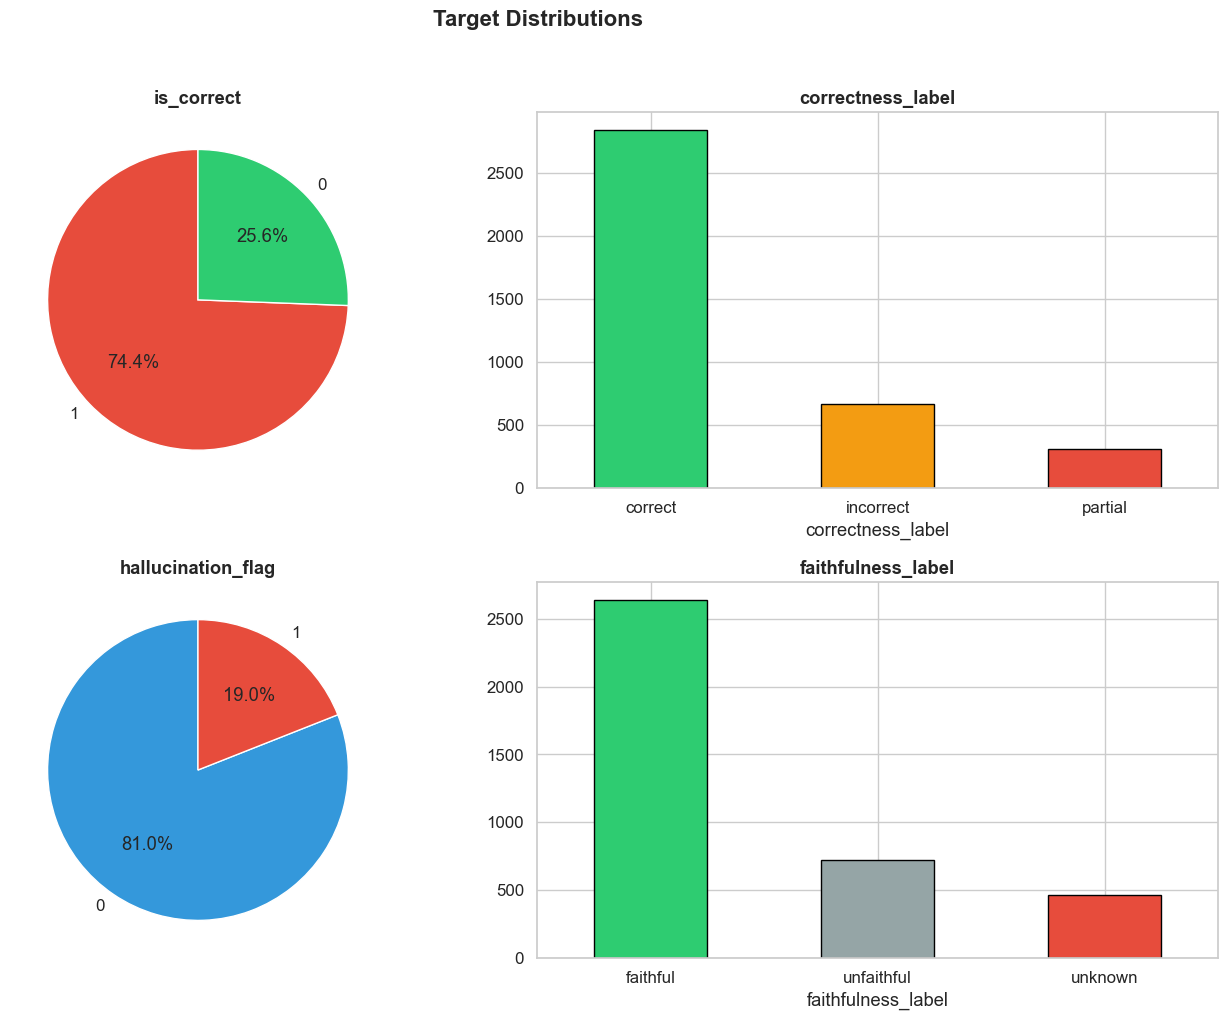

In [43]:
fig,axes=plt.subplots(2,2,figsize=(14,10))
eval_runs['is_correct'].value_counts().plot.pie(ax=axes[0,0],autopct='%1.1f%%',colors=['#e74c3c','#2ecc71'],startangle=90); axes[0,0].set_title('is_correct',fontweight='bold'); axes[0,0].set_ylabel('')
eval_runs['correctness_label'].value_counts().plot.bar(ax=axes[0,1],color=['#2ecc71','#f39c12','#e74c3c'],edgecolor='k'); axes[0,1].set_title('correctness_label',fontweight='bold'); axes[0,1].tick_params(axis='x',rotation=0)
eval_runs['hallucination_flag'].value_counts().plot.pie(ax=axes[1,0],autopct='%1.1f%%',colors=['#3498db','#e74c3c'],startangle=90); axes[1,0].set_title('hallucination_flag',fontweight='bold'); axes[1,0].set_ylabel('')
eval_runs['faithfulness_label'].value_counts().plot.bar(ax=axes[1,1],color=['#2ecc71','#95a5a6','#e74c3c'],edgecolor='k'); axes[1,1].set_title('faithfulness_label',fontweight='bold'); axes[1,1].tick_params(axis='x',rotation=0)
plt.suptitle('Target Distributions',fontsize=16,fontweight='bold',y=1.02); plt.tight_layout(); plt.show()

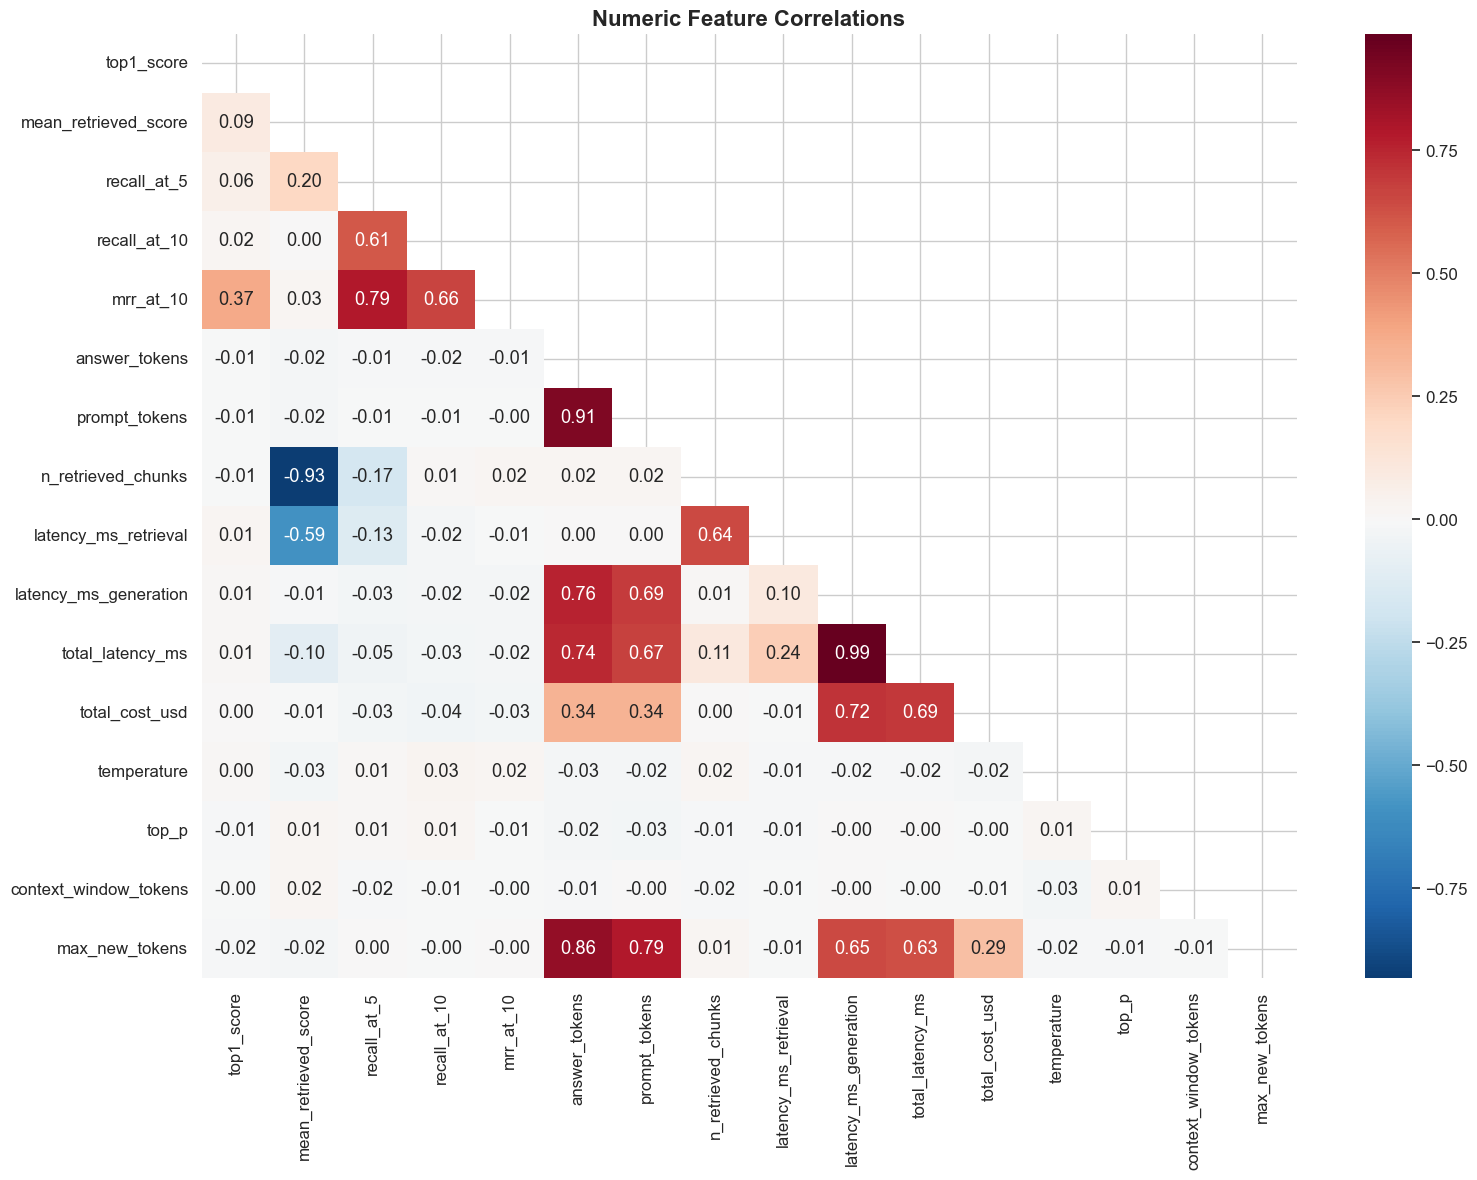

In [44]:
num_cols=['top1_score','mean_retrieved_score','recall_at_5','recall_at_10','mrr_at_10','answer_tokens','prompt_tokens','n_retrieved_chunks','latency_ms_retrieval','latency_ms_generation','total_latency_ms','total_cost_usd','temperature','top_p','context_window_tokens','max_new_tokens']
fig,ax=plt.subplots(figsize=(16,12))
mask=np.triu(np.ones_like(eval_runs[num_cols].corr(),dtype=bool))
sns.heatmap(eval_runs[num_cols].corr(),mask=mask,annot=True,fmt='.2f',cmap='RdBu_r',center=0,ax=ax)
ax.set_title('Numeric Feature Correlations',fontsize=16,fontweight='bold')
plt.tight_layout()
plt.show()

Performance by Generator Model:


,acc,hal,cost,n
generator_model,,,,
mistral-large,0.7658,0.1708,0.0004,521
gpt-4o-mini,0.7488,0.1862,0.0001,1214
llama-3.1-8b-instruct,0.7414,0.1820,0.0001,665
llama-3.1-70b-instruct,0.7365,0.1959,0.0004,296
gpt-4o,0.7340,0.1977,0.0025,688
claude-3.5-sonnet,0.7295,0.2205,0.0034,440


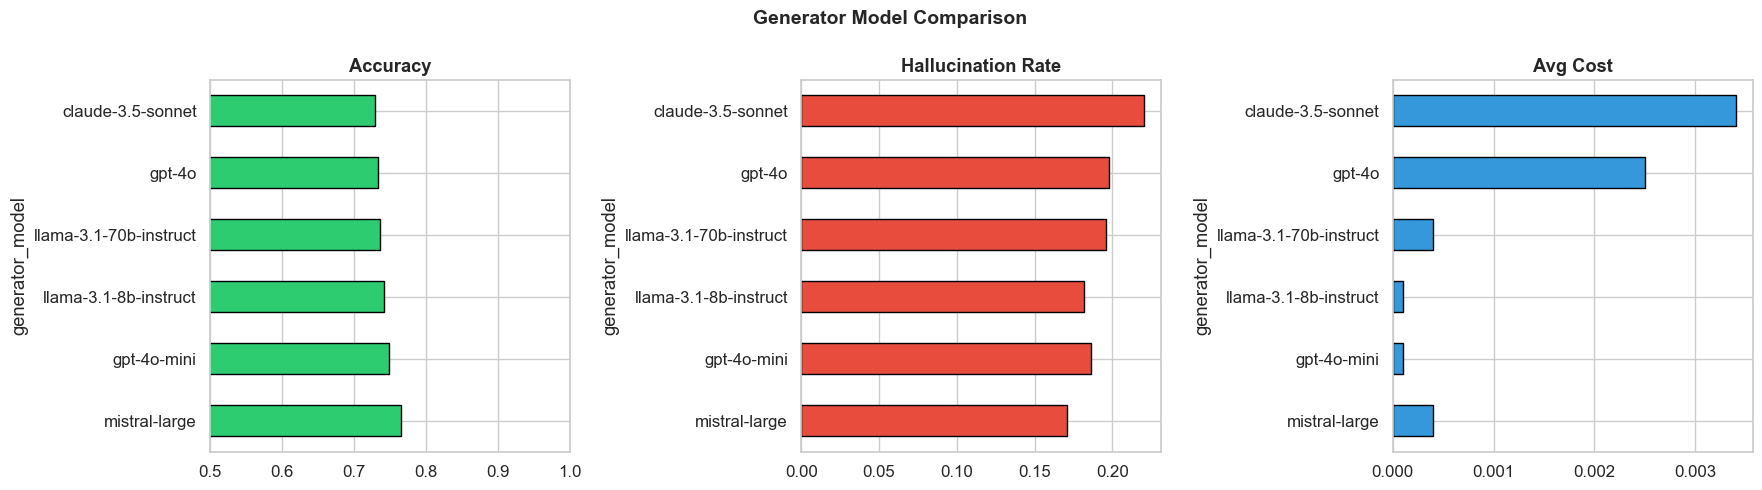

In [45]:
perf=eval_runs.groupby('generator_model').agg(acc=('is_correct','mean'),hal=('hallucination_flag','mean'),cost=('total_cost_usd','mean'),n=('run_id','count')).round(4).sort_values('acc',ascending=False)
print("Performance by Generator Model:"); display(perf)
fig,axes=plt.subplots(1,3,figsize=(18,5))
perf['acc'].plot.barh(ax=axes[0],color='#2ecc71',edgecolor='k'); axes[0].set_title('Accuracy',fontweight='bold'); axes[0].set_xlim(0.5,1)
perf['hal'].plot.barh(ax=axes[1],color='#e74c3c',edgecolor='k'); axes[1].set_title('Hallucination Rate',fontweight='bold')
perf['cost'].plot.barh(ax=axes[2],color='#3498db',edgecolor='k'); axes[2].set_title('Avg Cost',fontweight='bold')
plt.suptitle('Generator Model Comparison',fontsize=14,fontweight='bold'); plt.tight_layout(); plt.show()

Performance by Retrieval Strategy:


,acc,r5,r10,mrr,hal
retrieval_strategy,,,,,
bm25_then_rerank,0.7692,0.4363,0.8971,0.7828,0.1822
dense_then_rerank,0.7450,0.4300,0.8883,0.7706,0.1955
dense,0.7395,0.4293,0.8929,0.7720,0.1877
hybrid,0.7373,0.4344,0.8982,0.7649,0.1926
bm25,0.7294,0.4392,0.9003,0.7782,0.1922


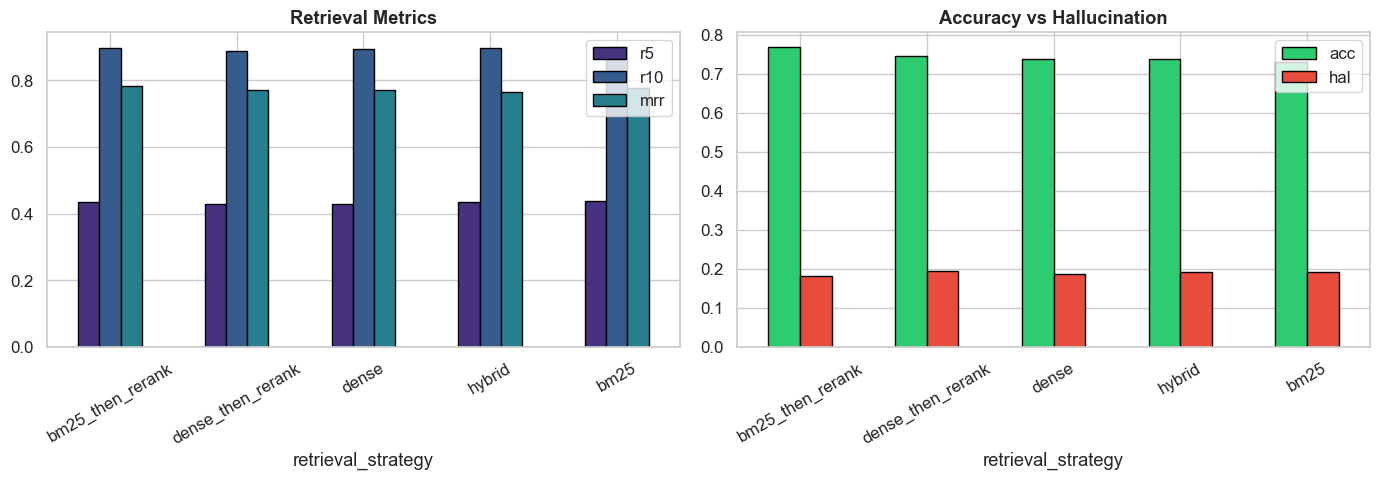

In [46]:
perf2=eval_runs.groupby('retrieval_strategy').agg(acc=('is_correct','mean'),r5=('recall_at_5','mean'),r10=('recall_at_10','mean'),mrr=('mrr_at_10','mean'),hal=('hallucination_flag','mean')).round(4).sort_values('acc',ascending=False)
print("Performance by Retrieval Strategy:"); display(perf2)
fig,axes=plt.subplots(1,2,figsize=(14,5))
perf2[['r5','r10','mrr']].plot.bar(ax=axes[0],edgecolor='k'); axes[0].set_title('Retrieval Metrics',fontweight='bold'); axes[0].tick_params(axis='x',rotation=30)
perf2[['acc','hal']].plot.bar(ax=axes[1],color=['#2ecc71','#e74c3c'],edgecolor='k'); axes[1].set_title('Accuracy vs Hallucination',fontweight='bold'); axes[1].tick_params(axis='x',rotation=30)
plt.tight_layout(); plt.show()

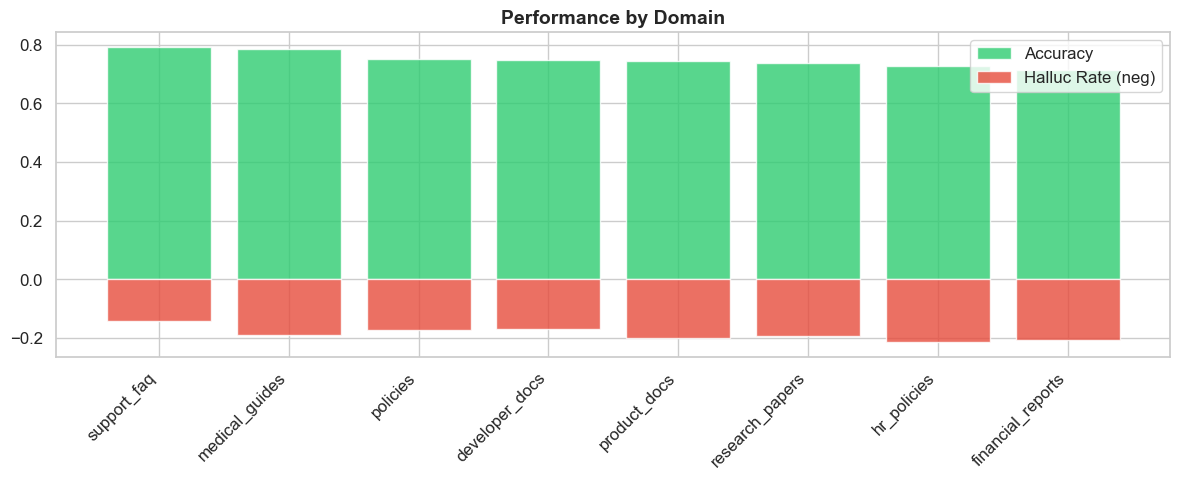

In [ ]:
perf3=eval_runs.groupby('domain').agg(acc=('is_correct','mean'),hal=('hallucination_flag','mean'),n=('run_id','count')).round(4).sort_values('acc',ascending=False)
fig,ax=plt.subplots(figsize=(12,5))
x=range(len(perf3))
ax.bar(x,perf3['acc'],color='#2ecc71',label='Accuracy',alpha=0.8); ax.bar(x,-perf3['hal'],color='#e74c3c',label='Halluc Rate (neg)',alpha=0.8)
ax.set_xticks(x); ax.set_xticklabels(perf3.index,rotation=45,ha='right'); ax.legend(); ax.set_title('Performance by Domain',fontweight='bold',fontsize=14); plt.tight_layout(); plt.show()

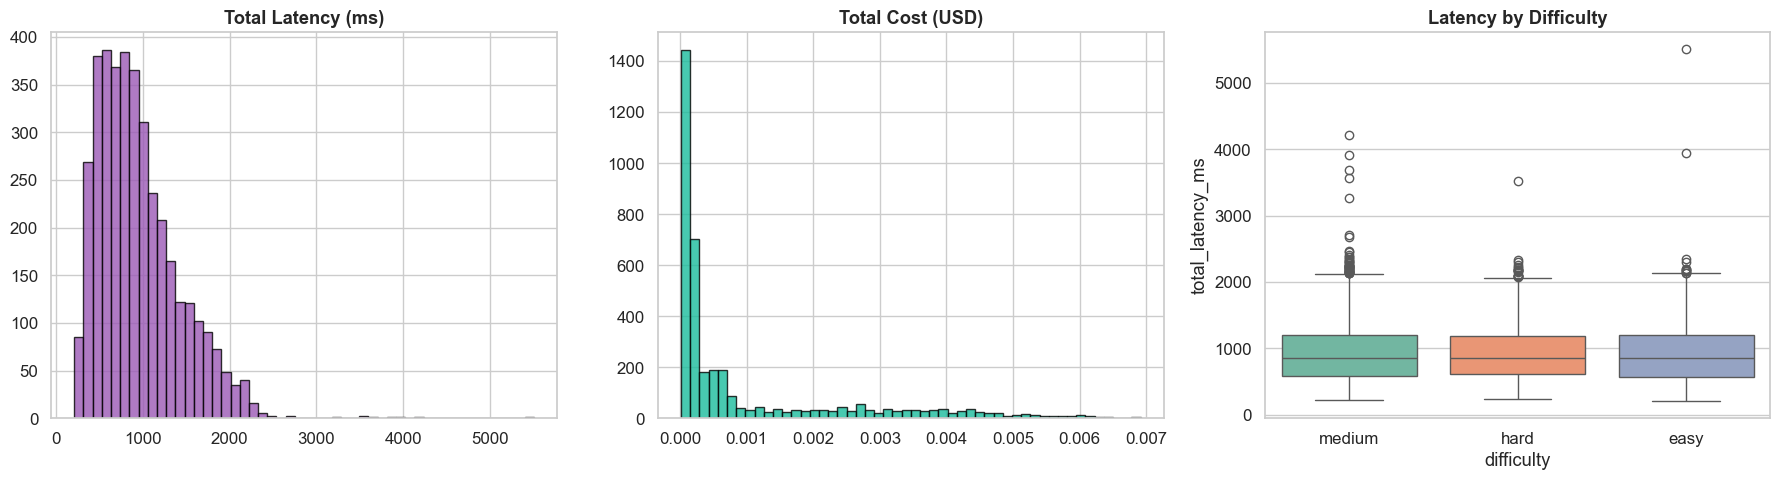

In [48]:
fig,axes=plt.subplots(1,3,figsize=(18,5))
eval_runs['total_latency_ms'].hist(bins=50,ax=axes[0],color='#9b59b6',edgecolor='k',alpha=0.8); axes[0].set_title('Total Latency (ms)',fontweight='bold')
eval_runs['total_cost_usd'].hist(bins=50,ax=axes[1],color='#1abc9c',edgecolor='k',alpha=0.8); axes[1].set_title('Total Cost (USD)',fontweight='bold')
sns.boxplot(data=eval_runs,x='difficulty',y='total_latency_ms',ax=axes[2],palette='Set2'); axes[2].set_title('Latency by Difficulty',fontweight='bold')
plt.tight_layout(); plt.show()

---
Feature Engineering

In [ ]:
cat_features=['domain','task_type','difficulty','retrieval_strategy','chunking_strategy','generator_model','embedding_model','reranker_model','eval_mode','stop_reason']
num_features=['top1_score','mean_retrieved_score','recall_at_5','recall_at_10','mrr_at_10','answer_tokens','prompt_tokens','n_retrieved_chunks','context_window_tokens','max_new_tokens','latency_ms_retrieval','latency_ms_generation','total_latency_ms','total_cost_usd','temperature','top_p']
flag_features=['used_long_context_window','has_relevant_in_top5','has_relevant_in_top10','is_noanswer_probe','has_answer_in_corpus','answered_without_retrieval']

df=eval_runs.copy()
label_encoders={}
for c in cat_features:
    le=LabelEncoder(); df[c+'_enc']=le.fit_transform(df[c].astype(str))
    label_encoders[c]=le

df['retrieval_x_difficulty']=df['top1_score']*df['difficulty_enc'] # Hard question + low retrieval → hallucination likely
df['recall5_x_nchunks']=df['recall_at_5']*df['n_retrieved_chunks'] #More relevant chunks → grounded answer likely.
df['score_gap']=df['top1_score']-df['mean_retrieved_score']  # bad if high
df['latency_ratio']=df['latency_ms_generation']/(df['latency_ms_retrieval']+1)
df['cost_per_token']=df['total_cost_usd']/(df['prompt_tokens']+df['answer_tokens']+1)
df['query_len']=df['query'].str.len()
df['query_word_count']=df['query'].str.split().str.len()

enc_cats=[c+'_enc' for c in cat_features]
interact=['retrieval_x_difficulty','recall5_x_nchunks','score_gap','latency_ratio','cost_per_token']
txt=['query_len','query_word_count']
ALL_FEATURES=num_features+flag_features+enc_cats+interact+txt
print(f"Total features: {len(ALL_FEATURES)}")

Total features: 39


In [ ]:
train=df[df['split']=='train'].copy()
val=df[df['split']=='val'].copy()
test=df[df['split']=='test'].copy()
print(f"Train:{len(train)} Val:{len(val)} Test:{len(test)}")
X_train,X_val,X_test=train[ALL_FEATURES].fillna(0),val[ALL_FEATURES].fillna(0),test[ALL_FEATURES].fillna(0)

Train:2803 Val:355 Test:666


---
## Section 4 — Model 1: Binary Correctness (`is_correct`)

In [ ]:
y_tr,y_v,y_te=train['is_correct'],val['is_correct'],test['is_correct']
models_bin={}
for name,clf in [('XGBoost',xgb.XGBClassifier(n_estimators=300,max_depth=6,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,use_label_encoder=False,eval_metric='logloss',random_state=42,n_jobs=-1)),
                 ('RandomForest',RandomForestClassifier(n_estimators=300,max_depth=12,random_state=42,n_jobs=-1)),
                 ('LightGBM',lgb.LGBMClassifier(n_estimators=300,max_depth=6,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,random_state=42,n_jobs=-1,verbose=-1))]:
    if 'XGB' in name: clf.fit(X_train,y_tr,eval_set=[(X_val,y_v)],verbose=False)
    elif 'Light' in name: clf.fit(X_train,y_tr,eval_set=[(X_val,y_v)])
    else: clf.fit(X_train,y_tr)
    p=clf.predict(X_test); pr=clf.predict_proba(X_test)[:,1]
    auc=roc_auc_score(y_te,pr); ap=average_precision_score(y_te,pr)
    models_bin[name]={'clf':clf,'pred':p,'proba':pr,'auc':auc,'ap':ap}
    print(f"\n{'='*60}\n{name} — TEST\n{'='*60}")
    print(classification_report(y_te,p,digits=4))
    print(f"ROC-AUC:{auc:.4f} PR-AUC:{ap:.4f}")
best_bin=max(models_bin,key=lambda k:models_bin[k]['auc'])
print(f"\nBest: {best_bin} AUC={models_bin[best_bin]['auc']:.4f}")


XGBoost — TEST
              precision    recall  f1-score   support

           0     0.9055    0.5990    0.7210       192
           1     0.8571    0.9747    0.9121       474

    accuracy                         0.8664       666
   macro avg     0.8813    0.7868    0.8166       666
weighted avg     0.8711    0.8664    0.8570       666

ROC-AUC:0.8674 PR-AUC:0.9192

RandomForest — TEST
              precision    recall  f1-score   support

           0     0.9820    0.5677    0.7195       192
           1     0.8505    0.9958    0.9174       474

    accuracy                         0.8724       666
   macro avg     0.9162    0.7817    0.8184       666
weighted avg     0.8884    0.8724    0.8603       666

ROC-AUC:0.8657 PR-AUC:0.9140

LightGBM — TEST
              precision    recall  f1-score   support

           0     0.9274    0.5990    0.7278       192
           1     0.8579    0.9810    0.9154       474

    accuracy                         0.8709       666
   macro avg    

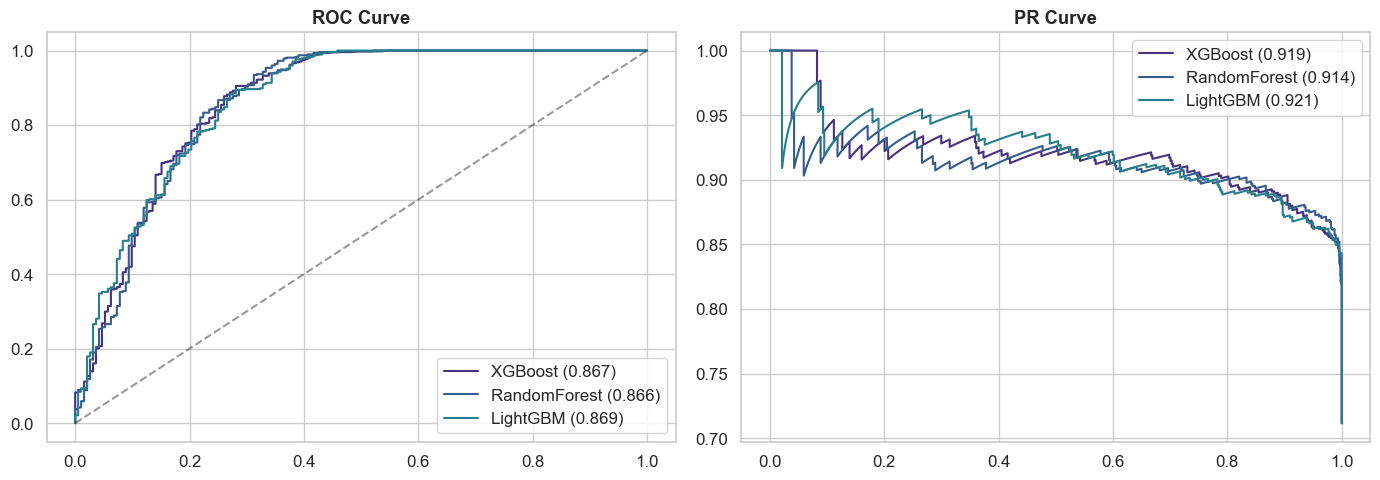

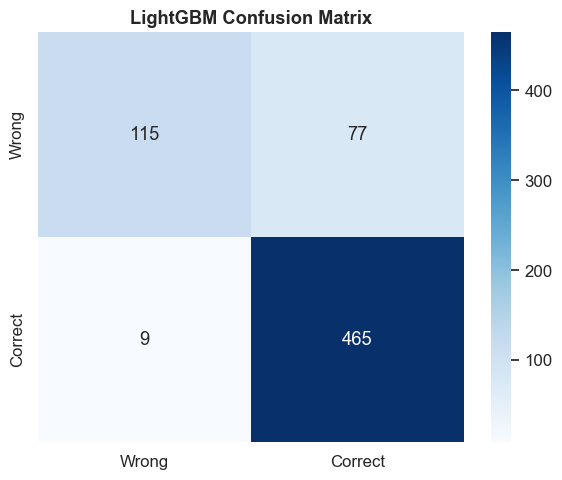

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(14,5))
for n,d in models_bin.items():
    fpr,tpr,_=roc_curve(y_te,d['proba'])
    axes[0].plot(fpr,tpr,label=f"{n} ({d['auc']:.3f})")
    pre,rec,_=precision_recall_curve(y_te,d['proba'])
    axes[1].plot(rec,pre,label=f"{n} ({d['ap']:.3f})")
axes[0].plot([0,1],[0,1],'k--',alpha=0.4); axes[0].set_title('ROC Curve',fontweight='bold'); axes[0].legend()
axes[1].set_title('PR Curve',fontweight='bold'); axes[1].legend()
plt.tight_layout(); plt.show()

fig,ax=plt.subplots(figsize=(6,5))
cm=confusion_matrix(y_te,models_bin[best_bin]['pred'])
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',ax=ax,xticklabels=['Wrong','Correct'],yticklabels=['Wrong','Correct'])
ax.set_title(f'{best_bin} Confusion Matrix',fontweight='bold'); plt.tight_layout(); plt.show()

---
## Multi-class Correctness 

XGBoost Multi-class:
              precision    recall  f1-score   support

     correct     0.8587    0.9873    0.9185       474
   incorrect     0.6239    0.5191    0.5667       131
     partial     0.1667    0.0328    0.0548        61

    accuracy                         0.8078       666
   macro avg     0.5497    0.5131    0.5133       666
weighted avg     0.7491    0.8078    0.7702       666

CatBoost Multi-class:
              precision    recall  f1-score   support

     correct     0.8505    0.9958    0.9174       474
   incorrect     0.6422    0.5344    0.5833       131
     partial     0.0000    0.0000    0.0000        61

    accuracy                         0.8138       666
   macro avg     0.4976    0.5100    0.5002       666
weighted avg     0.7316    0.8138    0.7677       666



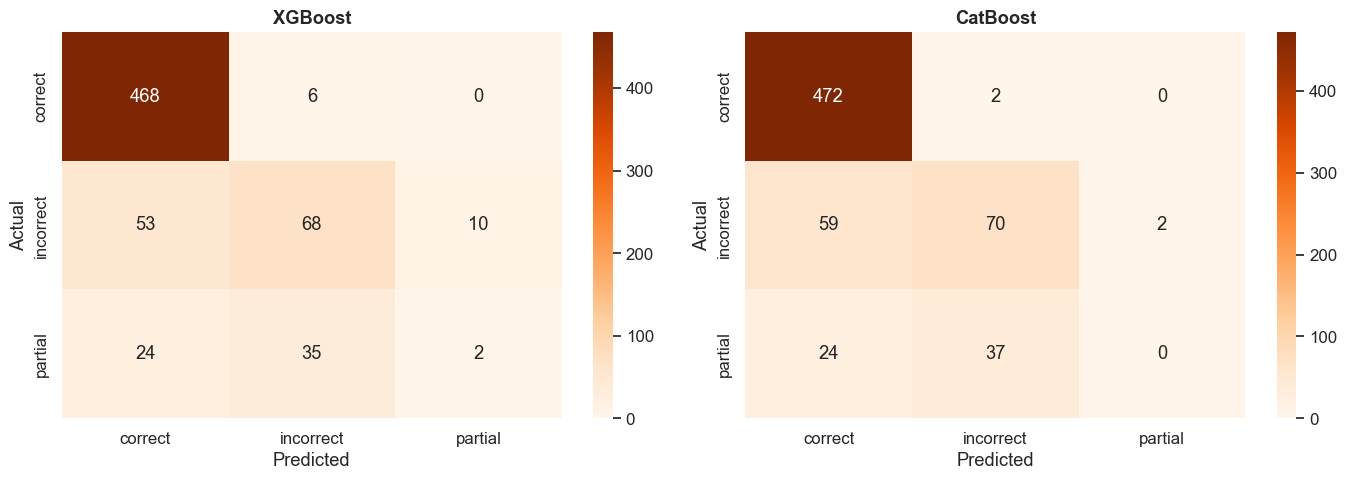

In [ ]:
le_c=LabelEncoder()
y_tr_mc=le_c.fit_transform(train['correctness_label'])
y_te_mc=le_c.transform(test['correctness_label'])
y_v_mc=le_c.transform(val['correctness_label'])
xgb_mc=xgb.XGBClassifier(objective='multi:softprob',num_class=3,n_estimators=300,max_depth=6,learning_rate=0.1,use_label_encoder=False,eval_metric='mlogloss',random_state=42,n_jobs=-1)
xgb_mc.fit(X_train,y_tr_mc,eval_set=[(X_val,y_v_mc)],verbose=False)
p1=xgb_mc.predict(X_test)
cat_mc=cb.CatBoostClassifier(iterations=300,depth=6,learning_rate=0.1,loss_function='MultiClass',random_seed=42,verbose=0)
cat_mc.fit(X_train,y_tr_mc,eval_set=(X_val,y_v_mc))
p2=cat_mc.predict(X_test).flatten().astype(int)
print("XGBoost Multi-class:")
print(classification_report(y_te_mc,p1,target_names=le_c.classes_,digits=4))
print("CatBoost Multi-class:")
print(classification_report(y_te_mc,p2,target_names=le_c.classes_,digits=4))

fig,axes=plt.subplots(1,2,figsize=(14,5))
for ax,pr,t in [(axes[0],p1,'XGBoost'),(axes[1],p2,'CatBoost')]:
    sns.heatmap(confusion_matrix(y_te_mc,pr),annot=True,fmt='d',cmap='Oranges',ax=ax,xticklabels=le_c.classes_,yticklabels=le_c.classes_)
    ax.set_title(t,fontweight='bold')
    ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
plt.tight_layout(); plt.show()

just prediciting yes coz of class imbalance

---
## Hallucination Detection 


XGBoost Hallucination Detection:
              precision    recall  f1-score   support

           0     0.8217    0.9344    0.8744       518
           1     0.5584    0.2905    0.3822       148

    accuracy                         0.7913       666
   macro avg     0.6901    0.6125    0.6283       666
weighted avg     0.7632    0.7913    0.7651       666

AUC:0.7126

LightGBM Hallucination Detection:
              precision    recall  f1-score   support

           0     0.8265    0.9382    0.8788       518
           1     0.5897    0.3108    0.4071       148

    accuracy                         0.7988       666
   macro avg     0.7081    0.6245    0.6430       666
weighted avg     0.7739    0.7988    0.7740       666

AUC:0.7032


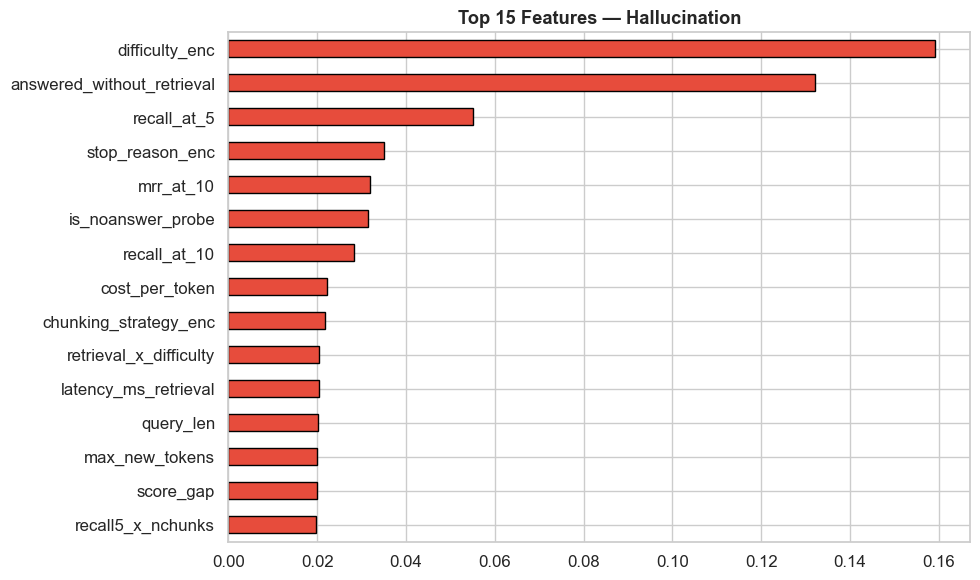

In [ ]:
y_tr_h,y_v_h,y_te_h=train['hallucination_flag'],val['hallucination_flag'],test['hallucination_flag']
spw=y_tr_h.value_counts()[0]/y_tr_h.value_counts()[1]
xgb_h=xgb.XGBClassifier(n_estimators=300,max_depth=6,learning_rate=0.1,scale_pos_weight=spw,use_label_encoder=False,eval_metric='aucpr',random_state=42,n_jobs=-1)
xgb_h.fit(X_train,y_tr_h,eval_set=[(X_val,y_v_h)],verbose=False)
lgb_h=lgb.LGBMClassifier(n_estimators=300,max_depth=6,learning_rate=0.1,is_unbalance=True,random_state=42,n_jobs=-1,verbose=-1)
lgb_h.fit(X_train,y_tr_h,eval_set=[(X_val,y_v_h)])
for n,c in [('XGBoost',xgb_h),('LightGBM',lgb_h)]:
    p=c.predict(X_test)
    pr=c.predict_proba(X_test)[:,1]
    print(f"\n{n} Hallucination Detection:") 
    print(classification_report(y_te_h,p,digits=4)) 
    print(f"AUC:{roc_auc_score(y_te_h,pr):.4f}")

fi=pd.Series(xgb_h.feature_importances_,index=ALL_FEATURES).sort_values(ascending=False).head(15)
fig,ax=plt.subplots(figsize=(10,6)); fi.plot.barh(ax=ax,color='#e74c3c',edgecolor='k')
ax.invert_yaxis()
ax.set_title('Top 15 Features — Hallucination',fontweight='bold'); plt.tight_layout()
plt.show()

## RAG Hallucination Failure Modes

Retrieval-Augmented Generation (RAG) systems can still hallucinate even when using external knowledge sources. Hallucination occurs when the generated answer is not supported by the retrieved evidence.

The table below summarizes the main hallucination mechanisms:

| Failure Mode | Description | Root Cause | Example |
|-------------|-------------|------------|---------|
| Retrieval Failure | No relevant document is retrieved, but the LLM still generates an answer | Retriever fails to find supporting evidence | Context has no revenue data, but LLM invents a revenue number |
| Weak Evidence | Retrieved document contains incomplete information, but LLM fills missing details | LLM predicts plausible details from prior training | Context says "revenue increased", LLM outputs exact fake amount |
| Context Misinterpretation | Correct document is retrieved, but LLM misunderstands the information | Semantic misinterpretation by LLM | Context shows 2022 revenue, LLM answers same for 2023 |
| Retrieval Noise | Irrelevant document is retrieved, leading to incorrect answer generation | Retrieval system selects wrong chunk | Context about Paris, LLM says Paris is capital of Germany |
| Overconfidence Generation | LLM adds facts not present in retrieved context | LLM relies on internal training instead of evidence | Context shows creator name, LLM invents creation year |
| No-Answer Hallucination | No answer exists in corpus, but LLM still generates response | Lack of grounding constraint enforcement | No Wakanda info in corpus, LLM invents capital |

**Conclusion:**  
Hallucinations occur due to failures in retrieval quality, evidence availability, or generation reliability. Detecting these failures using machine learning is critical for building trustworthy RAG systems.


---
## Section 7 — Model 4: Faithfulness (`faithfulness_label`)

XGBoost Faithfulness:
              precision    recall  f1-score   support

    faithful     0.7919    0.9795    0.8758       439
  unfaithful     0.6154    0.2740    0.3791       146
     unknown     0.3966    0.2840    0.3309        81

    accuracy                         0.7402       666
   macro avg     0.6013    0.5125    0.5286       666
weighted avg     0.7051    0.7402    0.7006       666

RF Faithfulness:
              precision    recall  f1-score   support

    faithful     0.7814    0.9932    0.8746       439
  unfaithful     0.6250    0.2740    0.3810       146
     unknown     0.3864    0.2099    0.2720        81

    accuracy                         0.7402       666
   macro avg     0.5976    0.4923    0.5092       666
weighted avg     0.6990    0.7402    0.6931       666



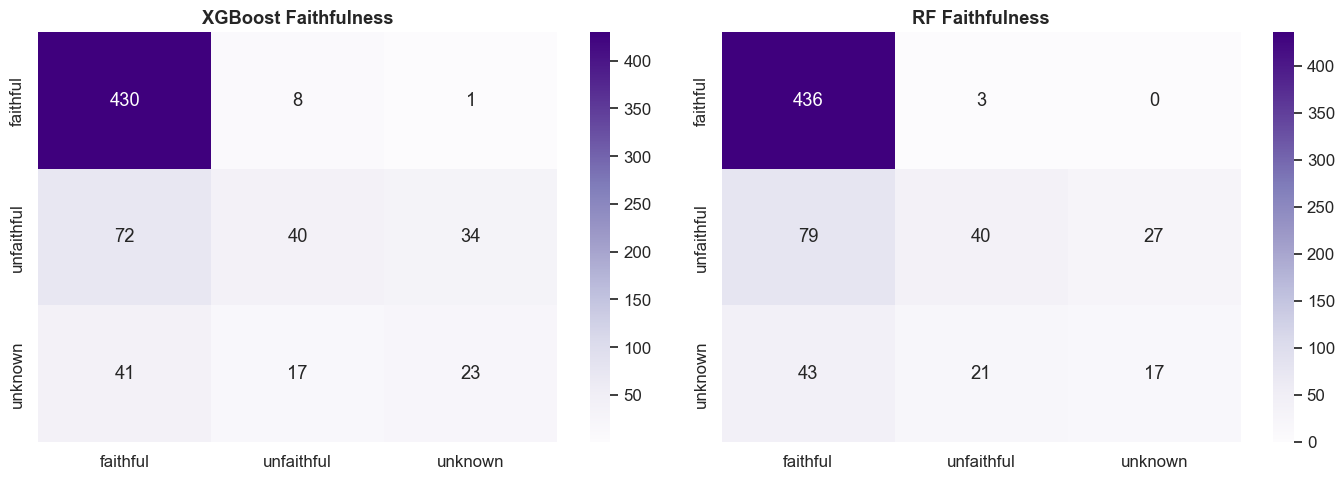

In [55]:
le_f=LabelEncoder(); y_tr_f=le_f.fit_transform(train['faithfulness_label']); y_te_f=le_f.transform(test['faithfulness_label']); y_v_f=le_f.transform(val['faithfulness_label'])
xgb_f=xgb.XGBClassifier(objective='multi:softprob',num_class=len(le_f.classes_),n_estimators=300,max_depth=6,learning_rate=0.1,random_state=42,n_jobs=-1,use_label_encoder=False,eval_metric='mlogloss')
xgb_f.fit(X_train,y_tr_f,eval_set=[(X_val,y_v_f)],verbose=False); pf1=xgb_f.predict(X_test)
rf_f=RandomForestClassifier(n_estimators=300,max_depth=12,random_state=42,n_jobs=-1)
rf_f.fit(X_train,y_tr_f); pf2=rf_f.predict(X_test)
print("XGBoost Faithfulness:"); print(classification_report(y_te_f,pf1,target_names=le_f.classes_,digits=4))
print("RF Faithfulness:"); print(classification_report(y_te_f,pf2,target_names=le_f.classes_,digits=4))

fig,axes=plt.subplots(1,2,figsize=(14,5))
for ax,pr,t in [(axes[0],pf1,'XGBoost'),(axes[1],pf2,'RF')]:
    sns.heatmap(confusion_matrix(y_te_f,pr),annot=True,fmt='d',cmap='Purples',ax=ax,xticklabels=le_f.classes_,yticklabels=le_f.classes_)
    ax.set_title(t+' Faithfulness',fontweight='bold')
plt.tight_layout(); plt.show()

---
## Section 8 — Model 5: Latency Regression (`total_latency_ms`)

XGBoost Latency: RMSE=179.7 MAE=106.2 R2=0.8648
RF Latency: RMSE=173.7 MAE=102.4 R2=0.8736


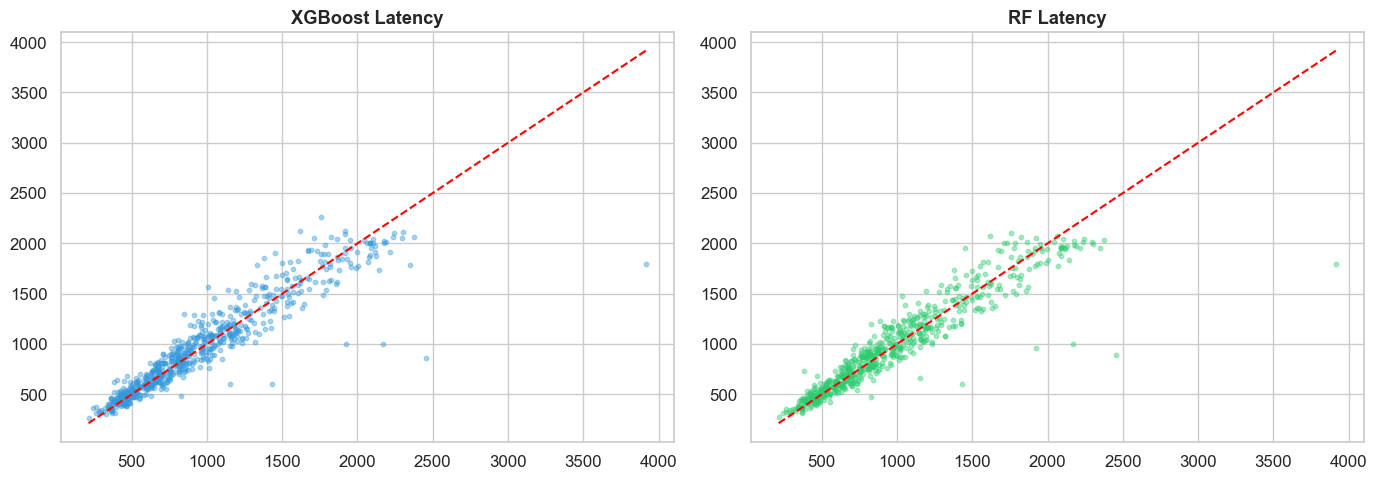

In [56]:
lat_f=[f for f in ALL_FEATURES if f not in ['latency_ms_retrieval','latency_ms_generation','total_latency_ms','latency_ratio']]
Xtr_l,Xte_l=X_train[lat_f],X_test[lat_f]; ytr_l,yte_l=train['total_latency_ms'],test['total_latency_ms']
xgb_r=xgb.XGBRegressor(n_estimators=300,max_depth=6,learning_rate=0.1,random_state=42,n_jobs=-1)
xgb_r.fit(Xtr_l,ytr_l,verbose=False); pr_x=xgb_r.predict(Xte_l)
rf_r=RandomForestRegressor(n_estimators=200,max_depth=12,random_state=42,n_jobs=-1)
rf_r.fit(Xtr_l,ytr_l); pr_r=rf_r.predict(Xte_l)
for n,p in [('XGBoost',pr_x),('RF',pr_r)]:
    print(f"{n} Latency: RMSE={np.sqrt(mean_squared_error(yte_l,p)):.1f} MAE={mean_absolute_error(yte_l,p):.1f} R2={r2_score(yte_l,p):.4f}")

fig,axes=plt.subplots(1,2,figsize=(14,5))
axes[0].scatter(yte_l,pr_x,alpha=0.4,s=10,c='#3498db'); axes[0].plot([yte_l.min(),yte_l.max()],[yte_l.min(),yte_l.max()],'r--'); axes[0].set_title('XGBoost Latency',fontweight='bold')
axes[1].scatter(yte_l,pr_r,alpha=0.4,s=10,c='#2ecc71'); axes[1].plot([yte_l.min(),yte_l.max()],[yte_l.min(),yte_l.max()],'r--'); axes[1].set_title('RF Latency',fontweight='bold')
plt.tight_layout(); plt.show()

---
## Cost Prediction (`total_cost_usd`)

Cost: RMSE=0.000130 MAE=0.000079 R2=0.9927


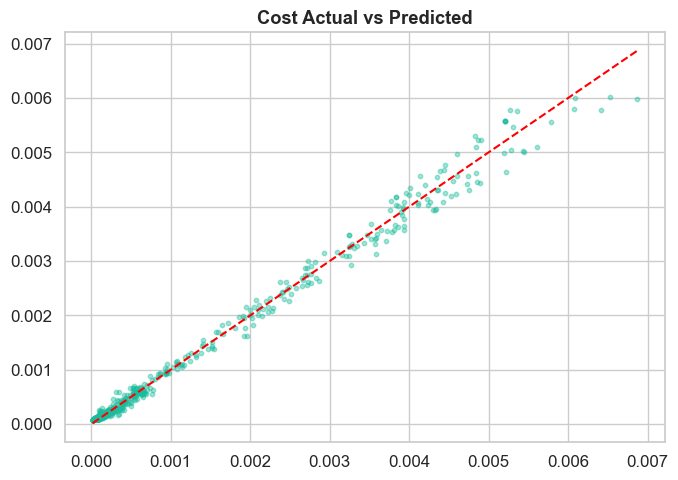

In [57]:
cost_f=[f for f in ALL_FEATURES if f not in ['total_cost_usd','cost_per_token']]
xgb_c=xgb.XGBRegressor(n_estimators=300,max_depth=6,learning_rate=0.1,random_state=42,n_jobs=-1)
xgb_c.fit(X_train[cost_f],train['total_cost_usd'],verbose=False); cost_pred=xgb_c.predict(X_test[cost_f])
print(f"Cost: RMSE={np.sqrt(mean_squared_error(test['total_cost_usd'],cost_pred)):.6f} MAE={mean_absolute_error(test['total_cost_usd'],cost_pred):.6f} R2={r2_score(test['total_cost_usd'],cost_pred):.4f}")
fig,ax=plt.subplots(figsize=(7,5)); ax.scatter(test['total_cost_usd'],cost_pred,alpha=0.4,s=10,c='#1abc9c')
ax.plot([test['total_cost_usd'].min(),test['total_cost_usd'].max()],[test['total_cost_usd'].min(),test['total_cost_usd'].max()],'r--')
ax.set_title('Cost Actual vs Predicted',fontweight='bold'); plt.tight_layout(); plt.show()

---
## Section 10 — NLP: TF-IDF Query Classification (`task_type`)

In [58]:
le_t=LabelEncoder(); 
ytr_t=le_t.fit_transform(train['task_type'])
yte_t=le_t.transform(test['task_type'])
for n,c in [('LogReg',LogisticRegression(max_iter=1000,C=1.0,random_state=42,n_jobs=-1)),('LinearSVM',LinearSVC(C=1.0,max_iter=2000,random_state=42))]:
    pipe=Pipeline([('tfidf',TfidfVectorizer(max_features=3000,ngram_range=(1,2),sublinear_tf=True)),('clf',c)])
    pipe.fit(train['query'],ytr_t); p=pipe.predict(test['query'])
    print(f"\n{n} Task Type:")
    print(classification_report(yte_t,p,target_names=le_t.classes_,digits=4))


LogReg Task Type:
                       precision    recall  f1-score   support

           comparison     0.0000    0.0000    0.0000        81
          explanation     0.1142    0.5190    0.1872        79
              factoid     0.0000    0.0000    0.0000        92
instruction_following     0.0000    0.0000    0.0000        94
            multi_hop     0.0000    0.0000    0.0000        98
        summarization     0.1262    0.5135    0.2027        74
             table_qa     0.0000    0.0000    0.0000        79
   temporal_reasoning     1.0000    0.0435    0.0833        69

             accuracy                         0.1231       666
            macro avg     0.1551    0.1345    0.0592       666
         weighted avg     0.1312    0.1231    0.0534       666


LinearSVM Task Type:
                       precision    recall  f1-score   support

           comparison     0.0000    0.0000    0.0000        81
          explanation     0.0000    0.0000    0.0000        79
          

---
## Section 11 — Clustering Analysis

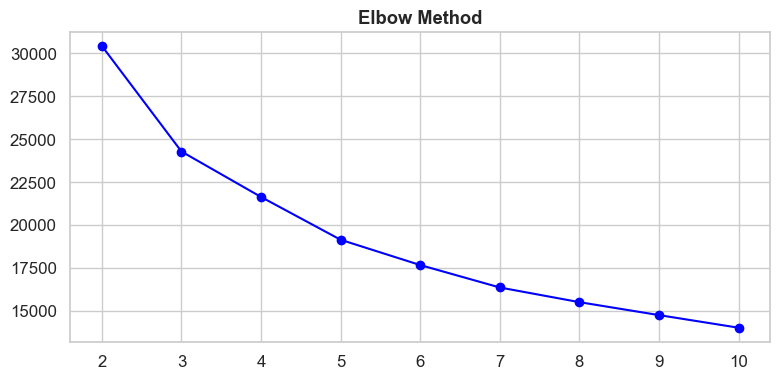

Cluster Profiles:


,acc,hal,r5,lat,cost,n
cluster,,,,,,
0,0.7440,0.1996,0.4789,1718.6754,0.0040,496
1,0.8158,0.1489,0.5363,622.4326,0.0005,1357
2,0.5084,0.3109,0.2726,813.3124,0.0005,653
3,0.6985,0.2328,0.0000,988.5254,0.0012,335
4,0.8169,0.1475,0.5243,1086.6378,0.0004,983


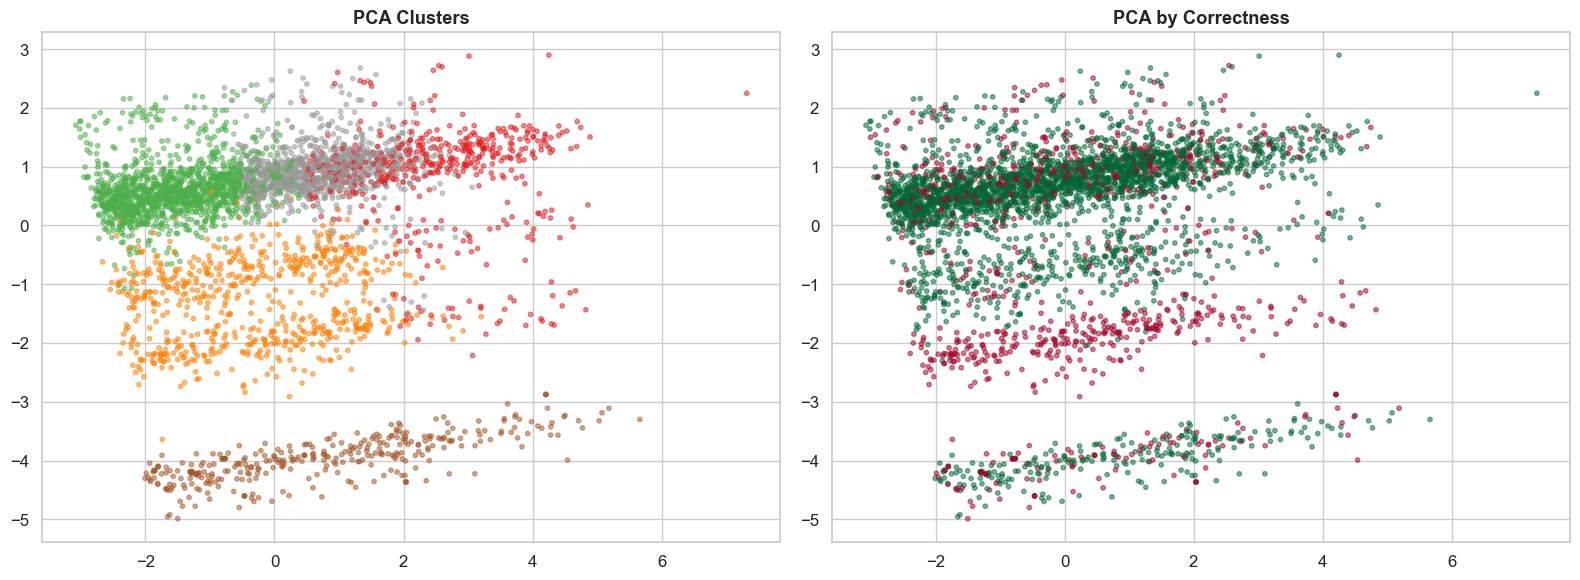

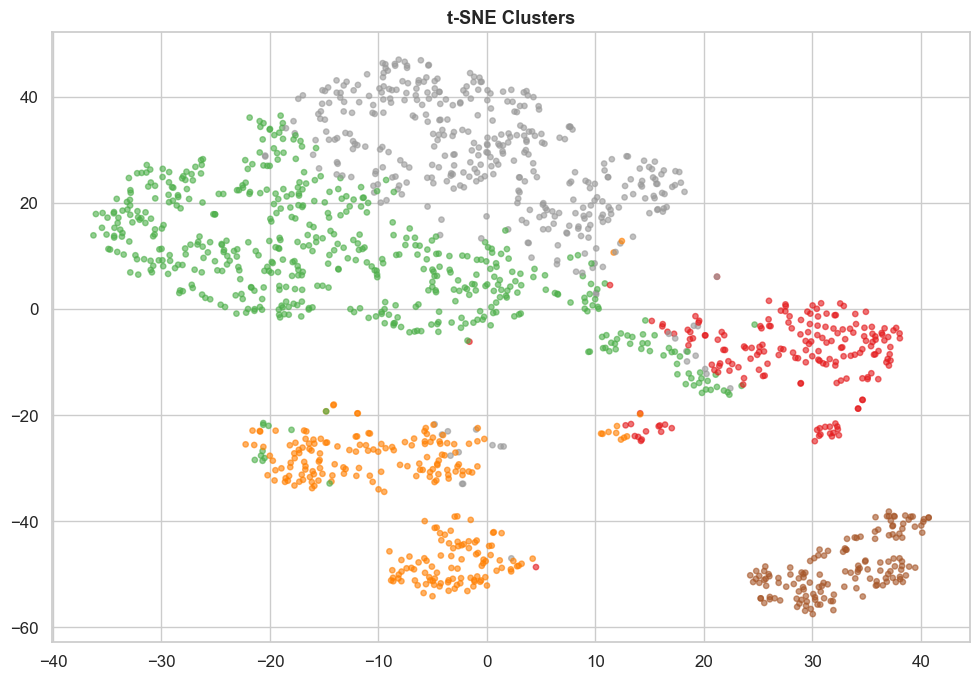

In [ ]:
cfeats=['top1_score','mean_retrieved_score','recall_at_5','recall_at_10','mrr_at_10','answer_tokens','prompt_tokens','total_latency_ms','total_cost_usd','temperature']
Xc=StandardScaler().fit_transform(df[cfeats].fillna(0))
inertias=[KMeans(n_clusters=k,random_state=42,n_init=10).fit(Xc).inertia_ for k in range(2,11)]
fig,ax=plt.subplots(figsize=(8,4)); ax.plot(range(2,11),inertias,'bo-')
ax.set_title('Elbow Method',fontweight='bold'); plt.tight_layout(); plt.show()

km=KMeans(n_clusters=5,random_state=42,n_init=10); df['cluster']=km.fit_predict(Xc)
clust_prof=df.groupby('cluster').agg(acc=('is_correct','mean'),hal=('hallucination_flag','mean'),r5=('recall_at_5','mean'),lat=('total_latency_ms','mean'),cost=('total_cost_usd','mean'),n=('run_id','count')).round(4)
print("Cluster Profiles:"); display(clust_prof)

pca=PCA(n_components=2,random_state=42); Xp=pca.fit_transform(Xc)
fig,axes=plt.subplots(1,2,figsize=(16,6))
axes[0].scatter(Xp[:,0],Xp[:,1],c=df['cluster'],cmap='Set1',alpha=0.5,s=10); axes[0].set_title('PCA Clusters',fontweight='bold')
axes[1].scatter(Xp[:,0],Xp[:,1],c=df['is_correct'],cmap='RdYlGn',alpha=0.5,s=10); axes[1].set_title('PCA by Correctness',fontweight='bold')
plt.tight_layout(); plt.show()

idx=np.random.RandomState(42).choice(len(Xc),min(1500,len(Xc)),replace=False)
Xt=TSNE(n_components=2,random_state=42,perplexity=30).fit_transform(Xc[idx])
fig,ax=plt.subplots(figsize=(10,7)); ax.scatter(Xt[:,0],Xt[:,1],c=df['cluster'].iloc[idx],cmap='Set1',alpha=0.6,s=15)
ax.set_title('t-SNE Clusters',fontweight='bold'); plt.tight_layout(); plt.show()

---
## Section 12 — SHAP Explainability

In [60]:
best_clf=models_bin[best_bin]['clf']
explainer=shap.TreeExplainer(best_clf)
sv=explainer.shap_values(X_test)
if isinstance(sv,list):
    sv=sv[1]
print(f"SHAP shape:{sv.shape} Model:{best_bin}")

SHAP shape:(666, 39) Model:LightGBM


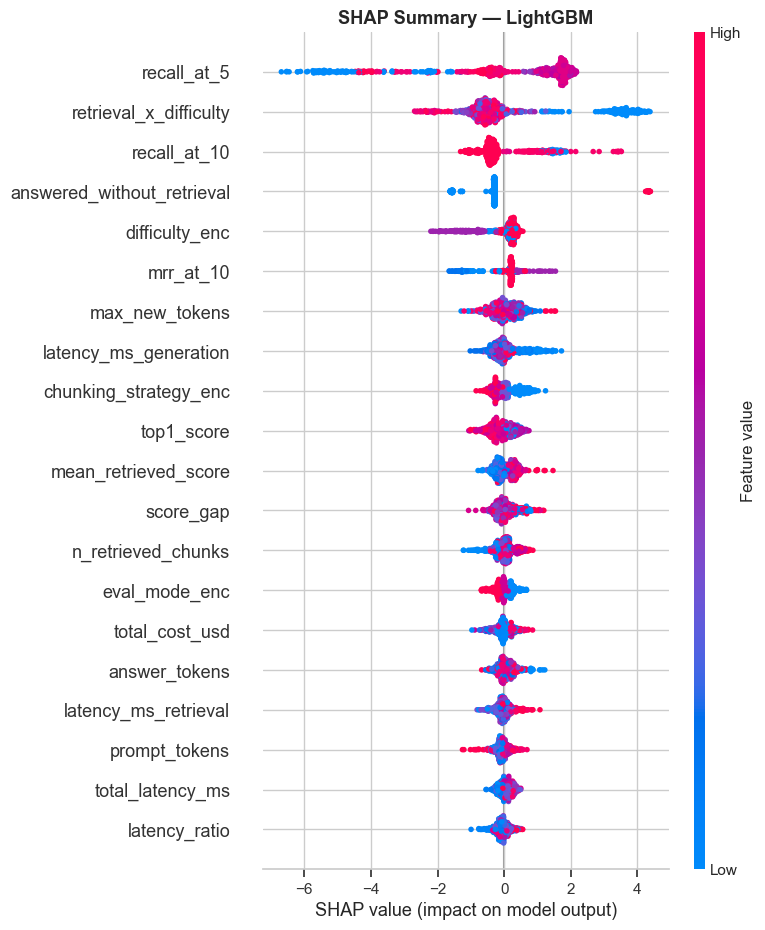

In [61]:
shap.summary_plot(sv,X_test,feature_names=ALL_FEATURES,show=False,max_display=20)
plt.title(f'SHAP Summary — {best_bin}',fontweight='bold'); plt.tight_layout(); plt.show()

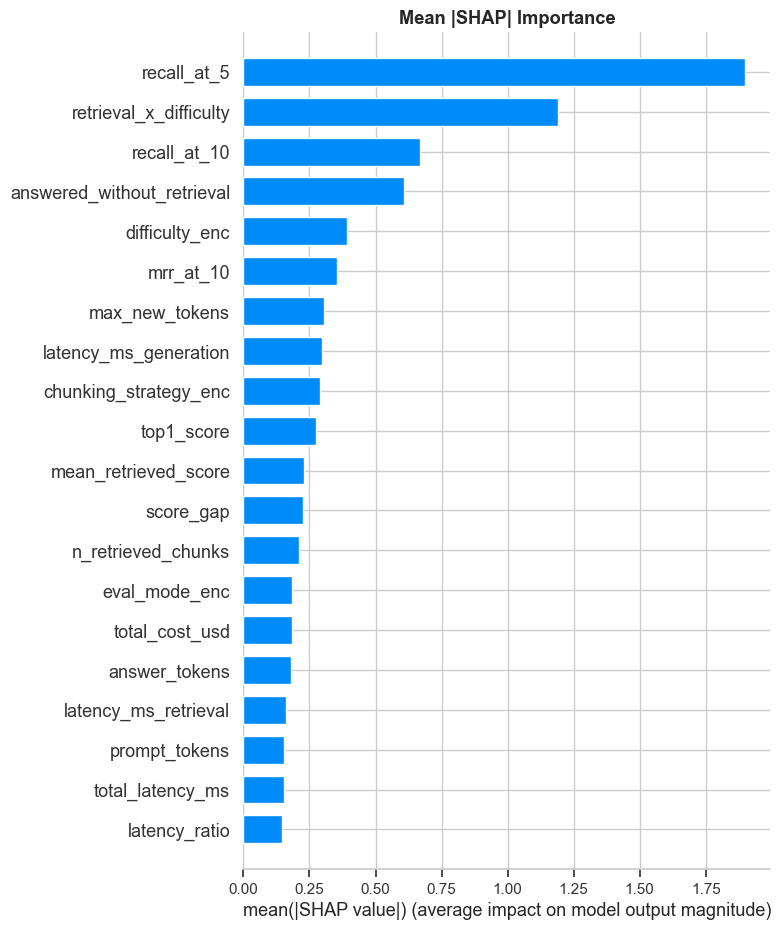

In [62]:
shap.summary_plot(sv,X_test,feature_names=ALL_FEATURES,plot_type='bar',show=False,max_display=20)
plt.title('Mean |SHAP| Importance',fontweight='bold'); plt.tight_layout(); plt.show()

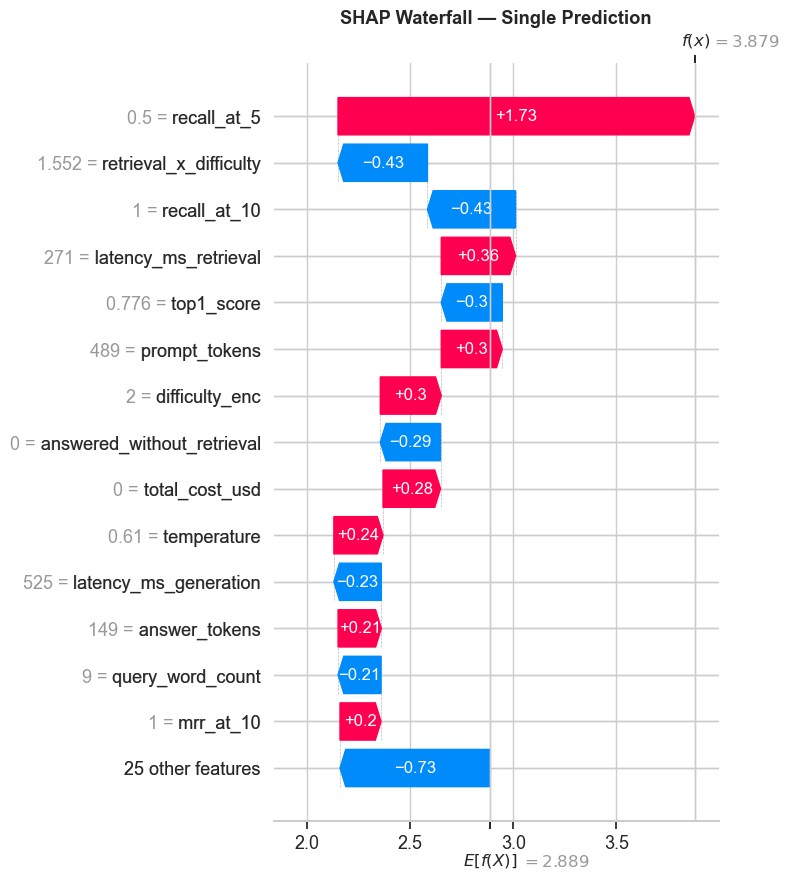

In [63]:
ev=explainer.expected_value if not isinstance(explainer.expected_value,list) else explainer.expected_value[1]
shap_exp=shap.Explanation(values=sv[0],base_values=ev,data=X_test.iloc[0].values,feature_names=ALL_FEATURES)
shap.waterfall_plot(shap_exp,show=False,max_display=15); plt.title('SHAP Waterfall — Single Prediction',fontweight='bold'); plt.tight_layout(); plt.show()

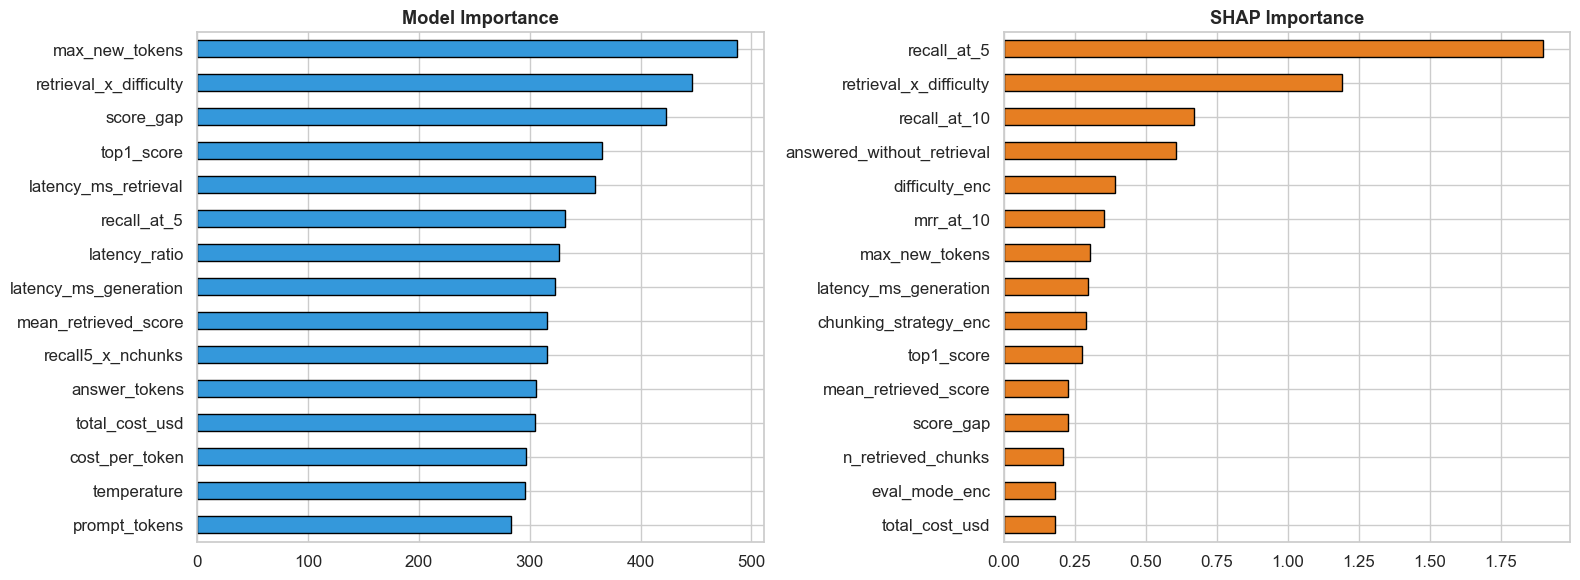

In [64]:
fig,axes=plt.subplots(1,2,figsize=(16,6))
pd.Series(best_clf.feature_importances_,index=ALL_FEATURES).sort_values(ascending=False).head(15).plot.barh(ax=axes[0],color='#3498db',edgecolor='k')
axes[0].invert_yaxis()
axes[0].set_title('Model Importance',fontweight='bold')
pd.Series(np.abs(sv).mean(0),index=ALL_FEATURES).sort_values(ascending=False).head(15).plot.barh(ax=axes[1],color='#e67e22',edgecolor='k')
axes[1].invert_yaxis()
axes[1].set_title('SHAP Importance',fontweight='bold')
plt.tight_layout()
plt.show()

In [65]:
res=[]
for n,d in models_bin.items(): res.append({'Model':n,'Task':'Binary Correctness','Acc':accuracy_score(y_te,d['pred']),'F1_macro':f1_score(y_te,d['pred'],average='macro'),'AUC':d['auc']})
for n,p in [('XGB_MC',p1),('CatBoost_MC',p2)]: res.append({'Model':n,'Task':'Multi-class Correct','Acc':accuracy_score(y_te_mc,p),'F1_macro':f1_score(y_te_mc,p,average='macro'),'AUC':np.nan})
for n,c in [('XGB_Hal',xgb_h),('LGB_Hal',lgb_h)]:
    p=c.predict(X_test) 
    pr=c.predict_proba(X_test)[:,1]
    res.append({'Model':n,'Task':'Hallucination','Acc':accuracy_score(y_te_h,p),'F1_macro':f1_score(y_te_h,p,average='macro'),'AUC':roc_auc_score(y_te_h,pr)})
for n,p in [('XGB_Faith',pf1),('RF_Faith',pf2)]: 
    res.append({'Model':n,'Task':'Faithfulness','Acc':accuracy_score(y_te_f,p),'F1_macro':f1_score(y_te_f,p,average='macro'),'AUC':np.nan})
rdf=pd.DataFrame(res).round(4); print("CLASSIFICATION RESULTS:"); display(rdf)

reg=[]
reg.append({'Model':'XGBoost','Task':'Latency','RMSE':np.sqrt(mean_squared_error(yte_l,pr_x)),'MAE':mean_absolute_error(yte_l,pr_x),'R2':r2_score(yte_l,pr_x)})
reg.append({'Model':'RF','Task':'Latency','RMSE':np.sqrt(mean_squared_error(yte_l,pr_r)),'MAE':mean_absolute_error(yte_l,pr_r),'R2':r2_score(yte_l,pr_r)})
reg.append({'Model':'XGBoost','Task':'Cost','RMSE':np.sqrt(mean_squared_error(test['total_cost_usd'],cost_pred)),'MAE':mean_absolute_error(test['total_cost_usd'],cost_pred),'R2':r2_score(test['total_cost_usd'],cost_pred)})
print("\nREGRESSION RESULTS:")
display(pd.DataFrame(reg).round(4))

CLASSIFICATION RESULTS:


,Model,Task,Acc,F1_macro,AUC
0,XGBoost,Binary Correctness,0.8664,0.8166,0.8674
1,RandomForest,Binary Correctness,0.8724,0.8184,0.8657
2,LightGBM,Binary Correctness,0.8709,0.8216,0.8686
3,XGB_MC,Multi-class Correct,0.8078,0.5133,NaN
4,CatBoost_MC,Multi-class Correct,0.8138,0.5002,NaN
5,XGB_Hal,Hallucination,0.7913,0.6283,0.7126
6,LGB_Hal,Hallucination,0.7988,0.6430,0.7032
7,XGB_Faith,Faithfulness,0.7402,0.5286,NaN
8,RF_Faith,Faithfulness,0.7402,0.5092,NaN



REGRESSION RESULTS:


,Model,Task,RMSE,MAE,R2
0,XGBoost,Latency,179.6853,106.2169,0.8648
1,RF,Latency,173.7186,102.4089,0.8736
2,XGBoost,Cost,0.0001,0.0001,0.9927


In [66]:
print("="*70+"\n BEST RAG CONFIGURATIONS\n"+"="*70)
for col,label in [('retrieval_strategy','Retrieval'),('generator_model','Generator'),('embedding_model','Embedding'),('chunking_strategy','Chunking')]:
    b=eval_runs.groupby(col)['is_correct'].mean().sort_values(ascending=False)
    print(f"Best {label}: {b.index[0]} (acc={b.iloc[0]:.4f})")

print("\nLowest Hallucination Configs:")
lh=eval_runs.groupby(['generator_model','retrieval_strategy'])['hallucination_flag'].mean().sort_values().head(5)
for idx,v in lh.items(): print(f"  {idx[0]}+{idx[1]}: {v:.4f}")

 BEST RAG CONFIGURATIONS
Best Retrieval: bm25_then_rerank (acc=0.7692)
Best Generator: mistral-large (acc=0.7658)
Best Embedding: e5-mistral-7b (acc=0.7563)
Best Chunking: by_heading (acc=0.7692)

Lowest Hallucination Configs:
  mistral-large+bm25_then_rerank: 0.1290
  mistral-large+bm25: 0.1348
  mistral-large+hybrid: 0.1471
  llama-3.1-70b-instruct+dense_then_rerank: 0.1471
  gpt-4o-mini+bm25_then_rerank: 0.1594


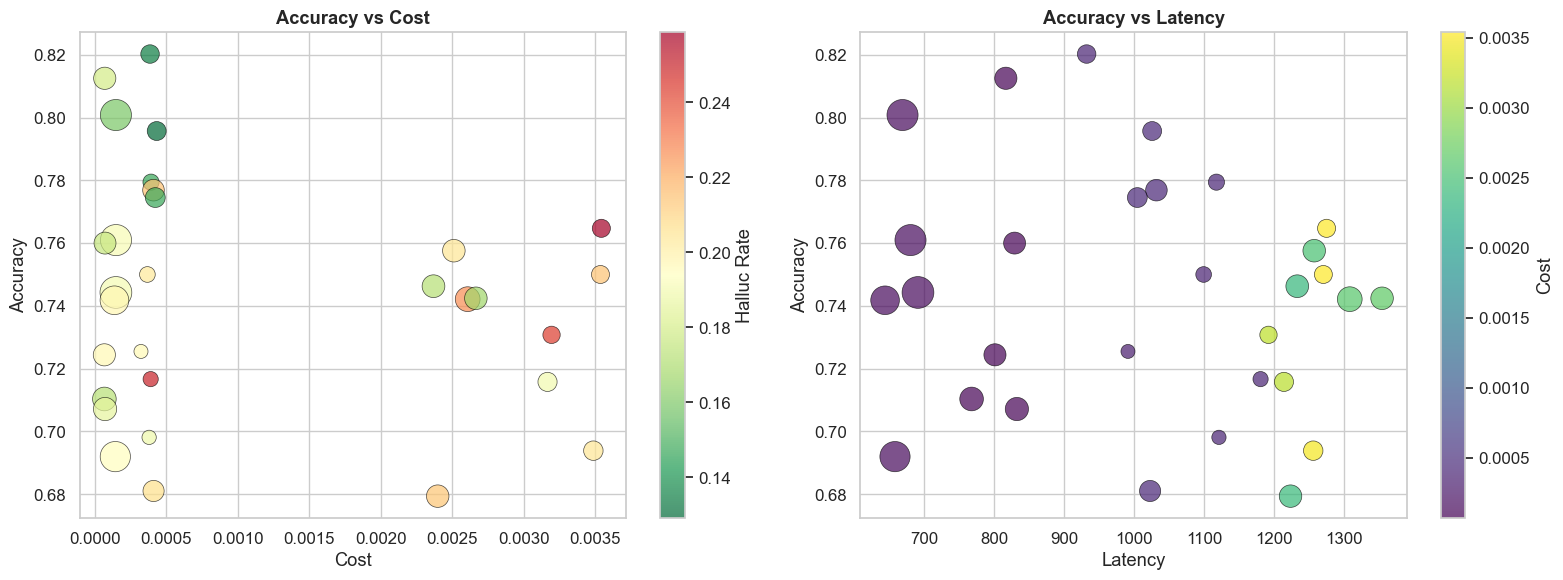

In [67]:
pareto=eval_runs.groupby(['generator_model','retrieval_strategy']).agg(acc=('is_correct','mean'),cost=('total_cost_usd','mean'),lat=('total_latency_ms','mean'),hal=('hallucination_flag','mean'),n=('run_id','count')).reset_index()
fig,axes=plt.subplots(1,2,figsize=(16,6))
s1=axes[0].scatter(pareto['cost'],pareto['acc'],c=pareto['hal'],cmap='RdYlGn_r',s=pareto['n']*2,alpha=0.7,edgecolor='k',linewidth=0.5)
axes[0].set_xlabel('Cost'); axes[0].set_ylabel('Accuracy'); axes[0].set_title('Accuracy vs Cost',fontweight='bold') 
plt.colorbar(s1,ax=axes[0],label='Halluc Rate')
s2=axes[1].scatter(pareto['lat'],pareto['acc'],c=pareto['cost'],cmap='viridis',s=pareto['n']*2,alpha=0.7,edgecolor='k',linewidth=0.5)
axes[1].set_xlabel('Latency')
axes[1].set_ylabel('Accuracy')    
axes[1].set_title('Accuracy vs Latency',fontweight='bold') 
plt.colorbar(s2,ax=axes[1],label='Cost')
plt.tight_layout()
plt.show()